# Business Cases for Data Science
## Business Case 1 - Predict Hotel Booking Cancellations
### Group AA
**Members**:
- Emil Ahmadov (m20201004@novaims.unl.pt)
- Doris Macean (m20200609@novaims.unl.pt)
- Doyun Shin (m20200565@novaims.unl.pt)
- Anastasiia Tagiltseva (m20200041@novaims.unl.pt)

<a class="anchor" id="0.1"></a>

# **Table of Contents**

1. [Business Understanding](#1)

2. [Data Understanding](#2)
  
3. [Data Preparation](#3)
   - 3.1 [Handling missing values](#3.1)
   - 3.2 [Outliers](#3.2) 
   - 3.3 [Feature engineering](#3.3) 
   - 3.4 [Feature Selection](#3.4) 
   - 3.5 [Encoding](#3.5)
   - 3.6 [Scaling](#3.6)
   
4. [Modeling](#4)
   - 4.1 [Random Forest](#4.1) 
   - 4.2 [Gradient Boosting](#4.2)
   - 4.3 [XGBoost](#4.3)
   
5. [Evaluation](#5)
 
6. [Deployment](#6)

# **1. Business Understanding** <a class="anchor" id="1"></a>

Company wants to understand the behavior of their customers based on the cancellations. They want to identify which customers are more likely to cancel their bookings and achieve these goals: 

- Understand which factors are effective on the decisions of customers to cancel their bookings, so that company can come up with specific actions to prevent cancellations 

- Predict number of cancellations for a specific time period and adjust overbooking policy accordingly 

- Implement better pricing policies 

#### Project Plan
| Phase | Time | Resources | Risks |
| :--: | :--------: |:--: | :--------: |
| Business Understanding | 1 day | All analysts | Economic and market changes |
| Data Understanding | 1 day | All analysts | Data problems, technological problems |
| Data Preparation | 2 days | Data scientists, DB engineers | Data problems, technological problems |
| Modeling |1 day | Data scientists | Technological problems, inability to build adequate model |
| Evaluation | 1 day | All analysts | Economic change inability to implement results |
| Deployment | 1 day | Data scientists, DB engineers, implementation team | Economic change inability to implement results |

# **2. Data Understanding** <a class="anchor" id="2"></a>

### Dataset description

- **ADR**: numeric - Average Daily Rate
- **Adults**: numeric - Number of adults
- **Agent**: categorical - ID of the travel agency that made the booking
- **ArrivalDateDayOfMonth**: numeric - Day of the month of the arrival date
- **ArrivalDateMonth**: numeric - Month of arrival date with 12 categories: “January” to “December”
- **ArrivalDateWeekNumber**: numeric - Week number of the arrival date
- **ArrivalDateYear**: numeric - Year of the arrival date
- **AssignedRoomType**: numeric - Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons
- **Babies**: numeric - Number of babies
- **BookingChanges**: numeric - Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- **Children**: numeric - Number of children
- **Company**: numeric - ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
- **Country**: categorical - Country of origin. Categories are represented in the ISO 3155-3:2013 format
- **CustomerType**: categorical -Type of booking, assuming one of four possible categories (Contract, Group, Transient, Transient-party)
- **DaysInWaitingList**: numeric - Number of days the booking was in the waiting list before it was confirmed to the customer
- **DepositType**: categorical - Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories (No Deposit, Non Refund, Refundable)
- **DistributionChannel**: categorical - Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **IsCanceled**: binary - Value indicating if the booking was canceled (1) or not (0)
- **IsRepeatedGuest**: binary - Value indicating if the booking name was from a repeated guest (1) or not (0)
- **LeadTime**: numeric - Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- **MarketSegment**: categorical - Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **Meal**: categorical - Type of meal booked. Categories are presented in standard hospitality meal packages (Undefined/SC (self-catering), BB, HB, FB)
- **PreviousBookingsNotCanceled**: numeric - Number of previous bookings not cancelled by the customer prior to the current booking
- **PreviousCancellations**: numeric - Number of previous bookings that were cancelled by the customer prior to the current booking
- **RequiredCarParkingSpaces**: numeric - Number of car parking spaces required by the customer
- **ReservationStatus**: categorical - Reservation last status, assuming one of three categories (Canceled, Check-Out, No-Show)
- **ReservationStatusDate**: date - Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel
- **ReservedRoomType**: categorical - Code of room type reserved. Code is presented instead of designation for anonymity reasons
- **StaysInWeekendNights**: numeric - Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **StaysInWeekNights**: numeric - Number of weeknights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **TotalOfSpecialRequests**: numeric - Number of special requests made by the customer (e.g. twin bed or high floor)

In [1]:
#standard
import os
import pandas as pd
import numpy as np
import calendar
import time
import phik
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import xgboost
from numpy import sort
import plotly.express as px
from itertools import combinations
from mlens.ensemble import SuperLearner 

#sklearn modelling
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder

#sklearn classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.feature_selection import SelectFromModel

#sklearn metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report, f1_score,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, plot_roc_curve
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings("ignore")

[MLENS] backend: threading


In [2]:
# read a xlsx file from current directory into DataFrame and save it to a variable called 'data'
df = pd.read_csv(os.path.join(os.getcwd(),'H2.csv'))

In [3]:
#copy
data=df.copy()

In [4]:
total_cancelations = data["IsCanceled"].sum()
# as percent:
rel_cancel = total_cancelations / data.shape[0] * 100
print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")

Total bookings canceled: 33,102 (42 %)


In [5]:
percentage = []
percentage.append(data['IsCanceled'].mean())
percentage.append(1-data['IsCanceled'].mean())
colors=['yellowgreen', 'gray']
fig = px.pie(values=percentage, names=['Canceled', 'Not Canceled'], title='Reservations', color={'Canceled' : 'yellowgreen', 'Not Canceled' : 'gray'})
fig.update_traces(marker = dict(colors=colors))
fig.show()

In [6]:
# get features types
target ='IsCanceled'
numeric = data.columns[(data.dtypes != 'O') & (data.columns != target)].tolist()
categorical = data.columns[data.dtypes == 'O'].tolist()
drop_columns = []
enc_columns = []

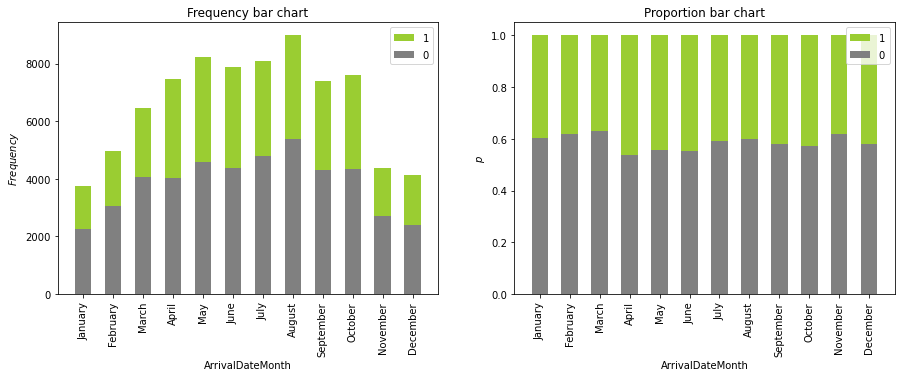

In [7]:
#Proportion and Frequency chart for ArrivalDateMonth
cont_tab = pd.crosstab(data['ArrivalDateMonth'], data['IsCanceled'], margins = True)
cats = ['January', 'February', 'March', 'April','May','June', 'July', 'August','September', 'October', 'November', 'December']
cont_tab.index = pd.CategoricalIndex(cont_tab.index, categories=cats, ordered=True)
cont_tab = cont_tab.sort_index()
        
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
p1 = plt.bar(cats, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
p2 = plt.bar(cats, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
plt.legend((p2[0], p1[0]), ('$1$', '$0$'))
plt.title("Frequency bar chart")
plt.xlabel('ArrivalDateMonth')
plt.ylabel("$Frequency$")
plt.xticks(rotation=90)

obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])

plt.subplot(122)
p1 = plt.bar(cats, obs_pct[0], 0.55, color="gray") #
p2 = plt.bar(cats, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen") #
plt.legend((p2[0], p1[0]), ('$1$', '$0$'))
plt.title("Proportion bar chart")
plt.xlabel('ArrivalDateMonth')
plt.ylabel("$p$")
plt.xticks(rotation=90)

plt.show()

In [8]:
drop_columns.append('ArrivalDateMonth')

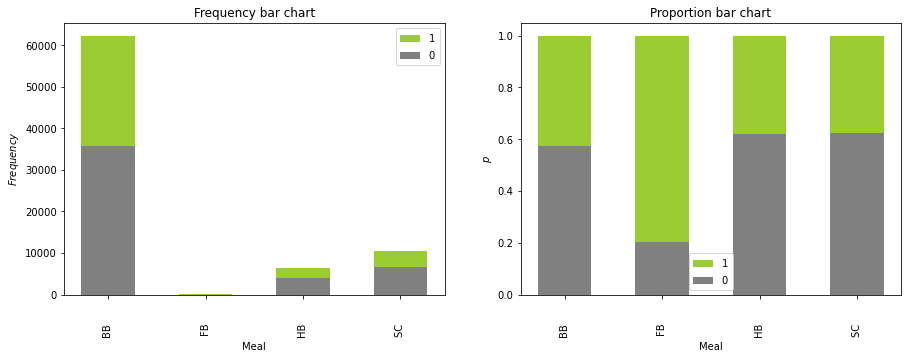

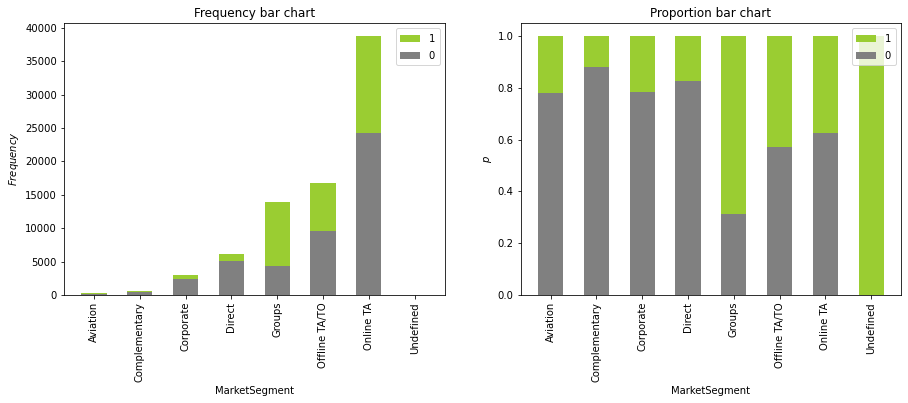

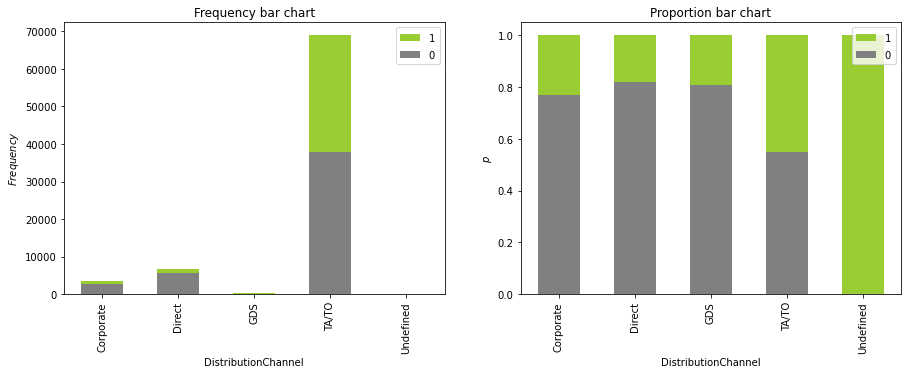

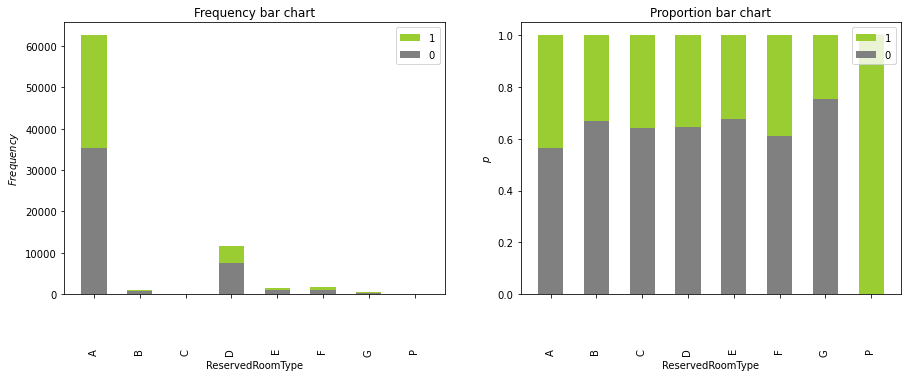

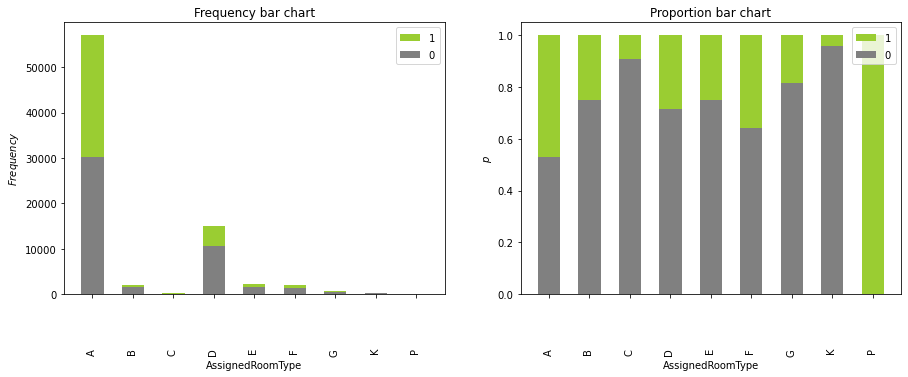

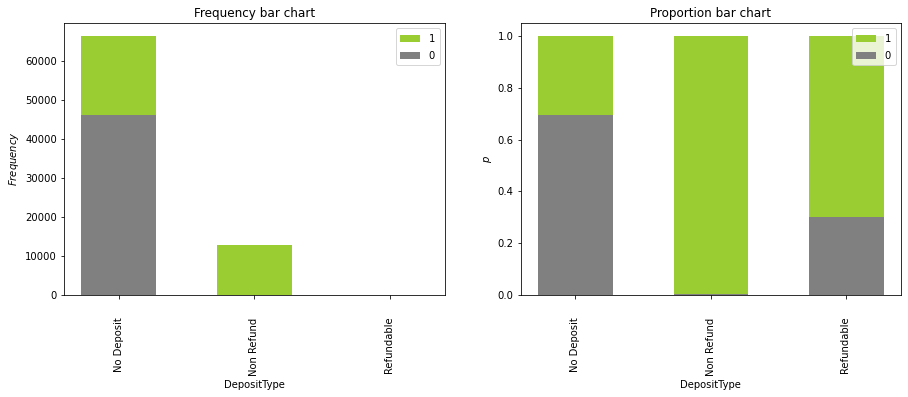

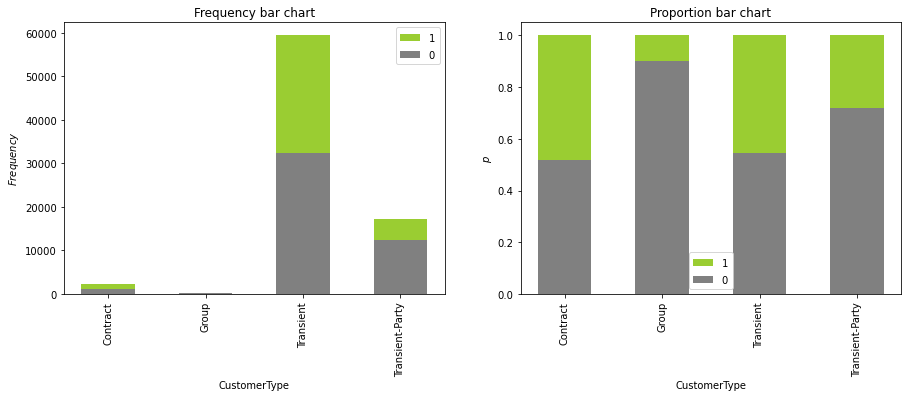

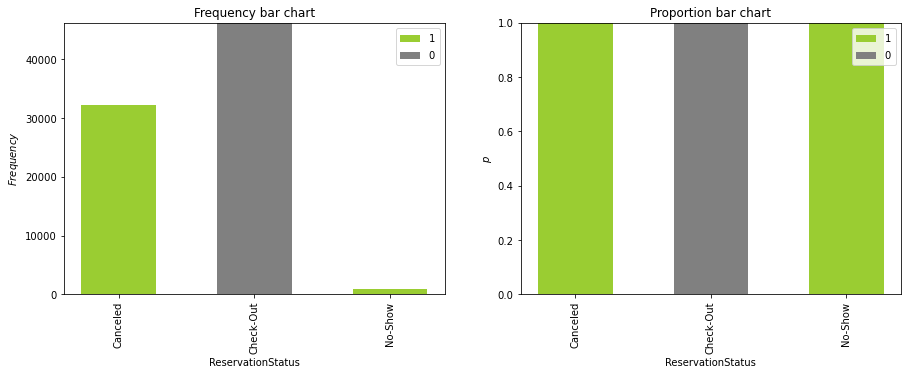

In [9]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$1$', '$0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")
    plt.xticks(rotation=90)

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray") #
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen") #
    plt.legend((p2[0], p1[0]), ('$1$', '$0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation=90)

    plt.show()
#['Meal', 'MarketSegment']
#dropped variables because their graphs are not very informative since there are a lot of categories
for i in ['Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType','ReservationStatus']:
    bar_charts_categorical(data, i, 'IsCanceled')

In [10]:
drop_columns.append('DepositType')
drop_columns.append('ReservationStatus')

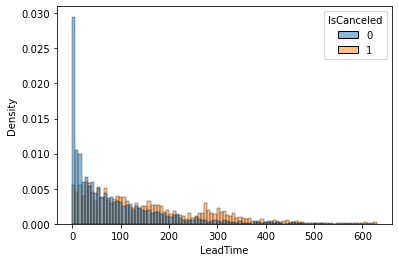

In [11]:
# Lead Time
sns.histplot(x=data['LeadTime'], hue=data['IsCanceled'], stat='density', common_norm=False)
plt.show()

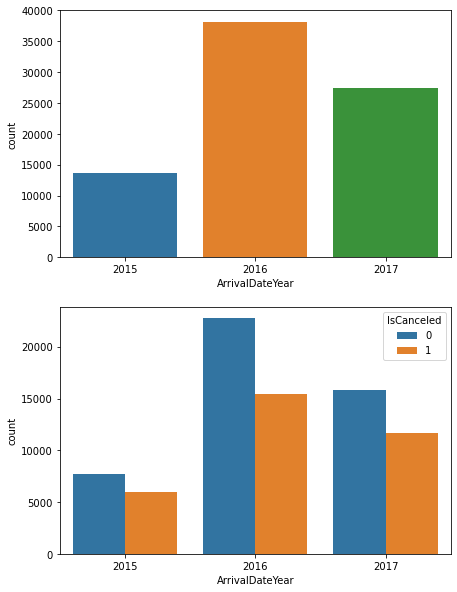

In [12]:
# There is possibly a slight proportion increase in cancels in 2017, however not a noticable difference
# between the years.  Will drop the year column due to its irrelevance in predicting future cancellations
fig, ax = plt.subplots(2,1, figsize=(7,10))
sns.countplot(data['ArrivalDateYear'], ax=ax[0])
sns.countplot(data['ArrivalDateYear'], hue=data['IsCanceled'], ax=ax[1])

drop_columns.append('ArrivalDateYear')

<AxesSubplot:xlabel='ArrivalDateWeekNumber', ylabel='Density'>

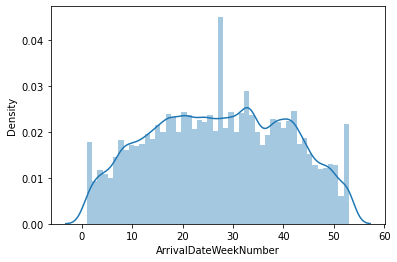

In [13]:
# more people traveling during the summer and then a spike during the Holidays
sns.distplot(data['ArrivalDateWeekNumber'])

<AxesSubplot:xlabel='ArrivalDateDayOfMonth', ylabel='Density'>

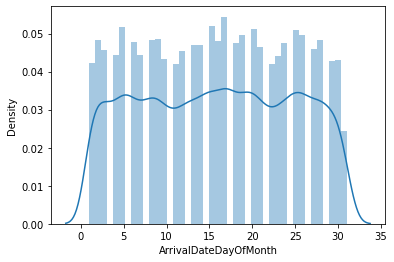

In [14]:
# there seems to be equal distribution of bookings on the days of the month
sns.distplot(data['ArrivalDateDayOfMonth'])

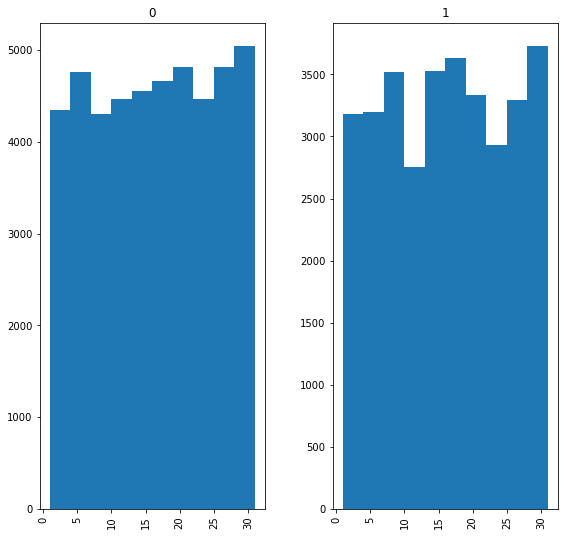

In [15]:
# Similar pattern between cancelled and non-cancelled with day of month, will drop this column too for 
# simplifying the model
data['ArrivalDateDayOfMonth'].hist(by=data['IsCanceled'], figsize=(9,9))
drop_columns.append('ArrivalDateDayOfMonth')

In [16]:
# Country - high cardinality
# show on map
temp = data['Country'].value_counts().reset_index().rename(columns={'index':'country','country':'count'})

guest_map = px.choropleth(temp,
                          locations=temp['country'],
                          color=np.log(temp['Country']), 
                          hover_name=temp['country'], 
                          color_continuous_scale=px.colors.sequential.Plasma,
                          title="Home country of guests")

guest_map.show()

drop_columns.append('Country')

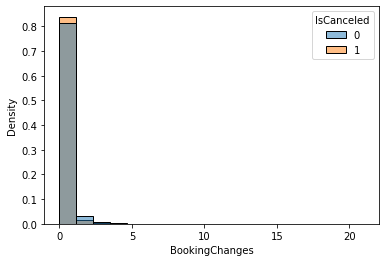

In [17]:
# Booking changes - 87% zeros
sns.histplot(x=data['BookingChanges'], hue=data['IsCanceled'], stat='density', common_norm=False)
plt.show()

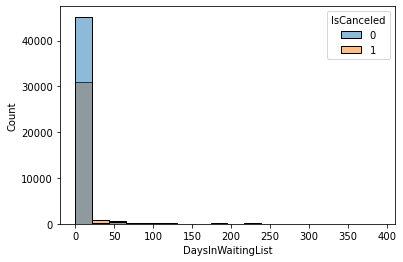

In [18]:
# days in waiting list ~ 96% zeros
sns.histplot(x=data['DaysInWaitingList'], hue=data['IsCanceled'], common_norm=False)
plt.show()

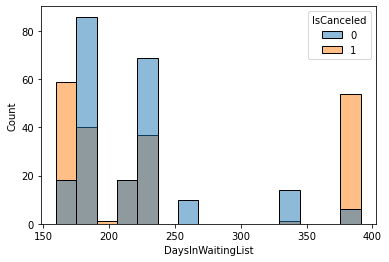

In [19]:
# curiosity 
sns.histplot(x=data[data['DaysInWaitingList'] > 150]['DaysInWaitingList'], hue=data['IsCanceled'], common_norm=False)
plt.show()

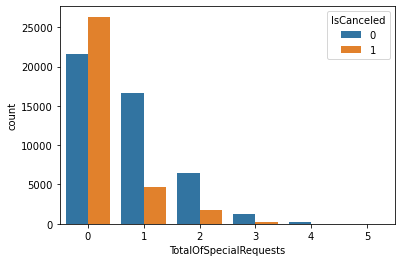

In [20]:
# SpecialRequests
sns.countplot(data=data, x='TotalOfSpecialRequests', hue='IsCanceled')
plt.show()

In [21]:
def weight_of_variable(df, column, target, sortby = '%'):
    # Count total observations
    total = df[[column, target]].groupby(by = column,).count().sort_values(by = column, ascending = False)
    # Count
    with_target = df[[column, target]].groupby(by = column).sum().sort_values(by = column, ascending = False)
    
    weight = round((df[[column, target]].groupby(by = column).sum().sort_values(by = column, ascending = False) / 
    (df[[column, target]].groupby(by = column).count().sort_values(by = column, ascending = False))).sort_values(by = column, ascending = False)*100,2)
    
    concat_df = pd.concat([total, with_target, weight],axis = 1)
    
    out = pd.DataFrame(concat_df.values,index=concat_df.index, columns=['Total count', 'Cancelled', '%'])
    # Explore feature vs target by catplot
    g = sns.catplot(x=column,y=target,data=df, kind="bar", size = 6,  height=.5,  ci=None, orient='v',  palette = "pastel")
    g.despine(left=True)
    g.fig.set_figwidth(8)
    g.fig.set_figheight(3*ceil(len(df[column].unique())/5))
    g.set_ylabels("Cancelation probability")
    
    return out.astype({'Total count':'int', 'Cancelled':'int64'}).sort_values(by = sortby ,ascending = False)

Total count  Cancelled      %
Meal                                    
FB                  44         35  79.55
BB               62305      26667  42.80
HB                6417       2437  37.98
SC               10564       3963  37.51

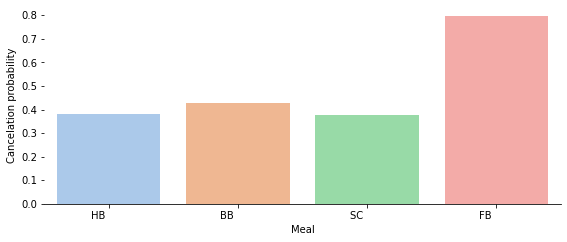

In [22]:
# in the pic below only interesting features, others don't have any bias 
weight_of_variable(data,column='Meal',target='IsCanceled')

Total count  Cancelled       %
MarketSegment                                
Undefined                2          2  100.00
Groups               13975       9623   68.86
Offline TA/TO        16747       7173   42.83
Online TA            38748      14491   37.40
Aviation               237         52   21.94
Corporate             2986        641   21.47
Direct                6093       1056   17.33
Complementary          542         64   11.81

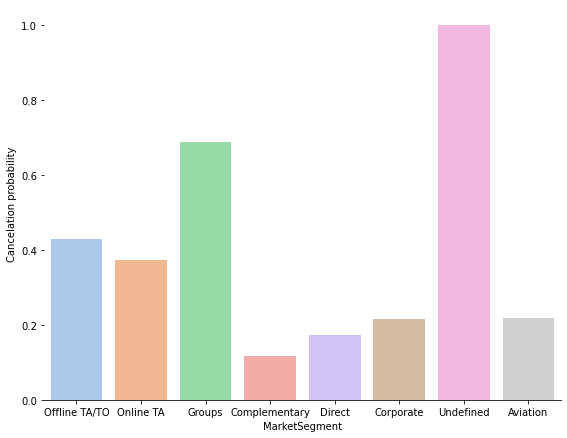

In [23]:
weight_of_variable(data,column='MarketSegment',target='IsCanceled')

Total count  Cancelled       %
DistributionChannel                                
Undefined                      4          4  100.00
TA/TO                      68945      31043   45.03
Corporate                   3408        786   23.06
GDS                          193         37   19.17
Direct                      6780       1232   18.17

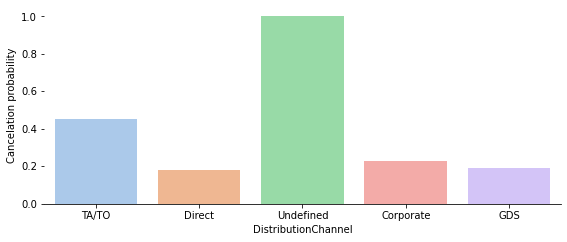

In [24]:
weight_of_variable(data,column='DistributionChannel',target='IsCanceled') 

Total count  Cancelled       %
ReservedRoomType                                
P                          10         10  100.00
A                       62595      27248   43.53
F                        1791        700   39.08
C                          14          5   35.71
D                       11768       4147   35.24
B                        1115        368   33.00
E                        1553        505   32.52
G                         484        119   24.59

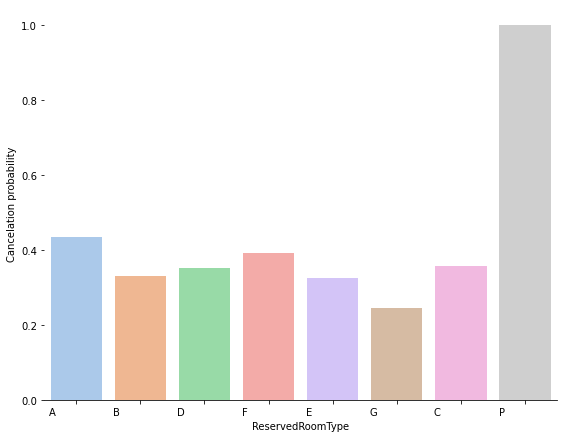

In [25]:
weight_of_variable(data,column='ReservedRoomType',target='IsCanceled')

Total count  Cancelled       %
AssignedRoomType                                
P                          10         10  100.00
A                       57007      26901   47.19
F                        2018        719   35.63
D                       14983       4273   28.52
B                        2004        503   25.10
E                        2168        540   24.91
G                         700        129   18.43
C                         161         15    9.32
K                         279         12    4.30

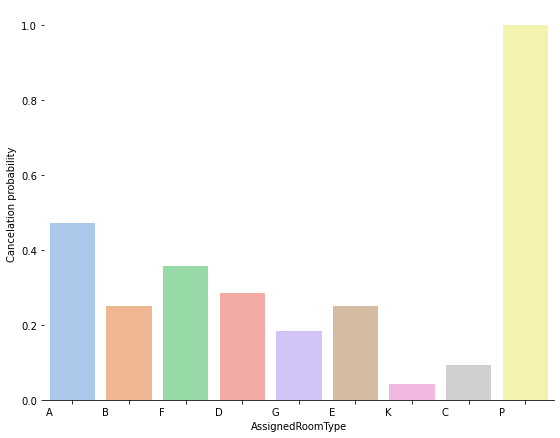

In [26]:
weight_of_variable(data,column='AssignedRoomType',target='IsCanceled')

Total count  Cancelled      %
CustomerType                                  
Contract                2300       1105  48.04
Transient              59404      27098  45.62
Transient-Party        17333       4870  28.10
Group                    293         29   9.90

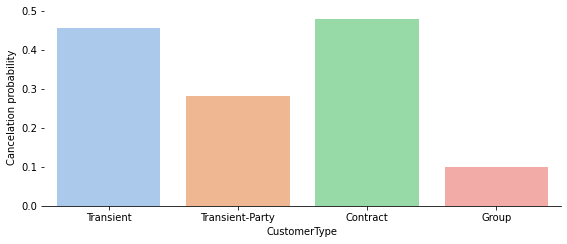

In [27]:
weight_of_variable(data,column='CustomerType',target='IsCanceled')

# **3. Data Preparation** <a class="anchor" id="3"></a>

## **3.1. Handling missing values** <a class="anchor" id="3.1"></a>

In [28]:
#replace 'NULL' with NaN value to easily detect
data.replace( 'NULL', np.nan, regex=True, inplace = True)

In [29]:
# Check for missins values in each features
print('----------- dataset % missing -------------')
percent_missing = (data.isna().sum()) * 100/len(data)
print(round(percent_missing[percent_missing>0].sort_values(ascending = False),2))

----------- dataset % missing -------------
Company     95.35
Agent       10.25
Country      0.03
Children     0.01
dtype: float64


In [30]:
# children: If no children is given, booking was most likely made without one
data.fillna(0,inplace = True)

In [31]:
# missing values 
data = data.drop(['Company'], axis=1)

## **3.2. Outliers** <a class="anchor" id="3.2"></a>

In [32]:
# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# for our goal we will drop these entries with no guests from training dataset
zero_guests = list(data.loc[data["Adults"]+ data["Children"]+ data["Babies"]==0].index)
data.drop(data.index[zero_guests], inplace=True)

In [33]:
# with 10 babies?
data[data.Babies>5][['Adults', 'Children', 'Babies']]

Adults  Children  Babies
6559        2       0.0      10
38596       1       0.0       9

In [34]:
data.drop(data[data.Babies>5].index, inplace = True) #inplace = True

In [35]:
print('Deleted rows:', (df.shape[0] - data.shape[0]),'Percentage of data kept after removing outliers:', np.round(data.shape[0] / df.shape[0]*100, 2), sep='\n')

Deleted rows:
169
Percentage of data kept after removing outliers:
99.79


## 3.3 Feature engineering <a class="anchor" id="3.3"></a>

In [36]:
# perform pre-processing on "meal" contains values "Undefined",
#which is equal to SC (as mentioned in by the contributor of the dataset)
data["Meal"].replace("Undefined", "SC", inplace=True)

In [37]:
# transforming month to numeric representation
monthDict = {month: index for index, month in enumerate(calendar.month_name) if month}

data['ArrivalDateMonth'] = [monthDict[x] for x in data['ArrivalDateMonth']]

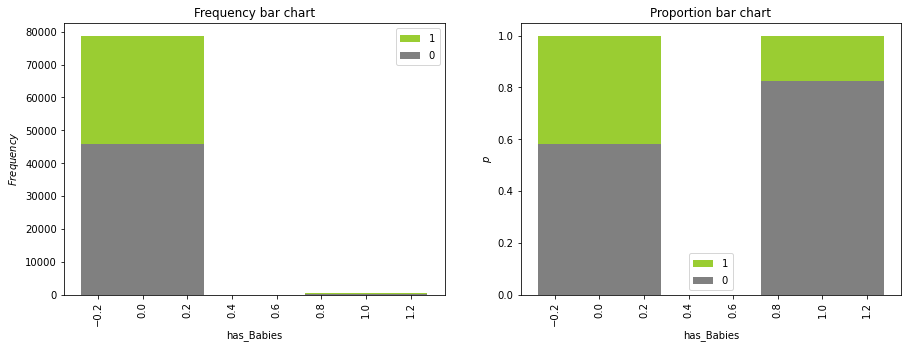

In [38]:
#CREATE binary has_babies
data['BabiesO'] = data['Babies'].map(str)
data['has_Babies'] = data['BabiesO'].map({'0': 0, '1': 1,'2':1,})
data.drop(['BabiesO'], axis=1,inplace=True)
bar_charts_categorical(data, 'has_Babies', 'IsCanceled')

In [39]:
def family(data):
    if ((data['Adults'] > 0) & (data['Children'] > 0)):
        val = 1
    elif ((data['Adults'] > 0) & (data['Babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

In [40]:
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_guests"] = data["Adults"]+ data["Children"]+ data["Babies"]
    #data["total_nights"] = data["StaysInWeekNights"]+ data["StaysInWeekendNights"]
    return data

data = feature(data)
data.drop(['Babies'], axis=1, inplace=True)

Total count  Cancelled      %
is_family                               
0                73983      31301  42.31
1                 5178       1778  34.34

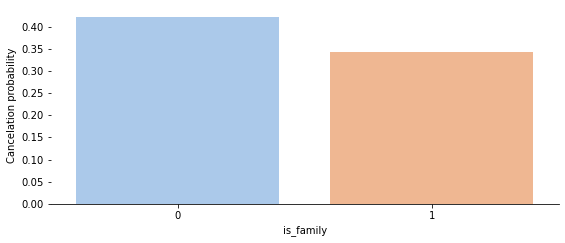

In [41]:
weight_of_variable(data,column='is_family',target='IsCanceled')

In [42]:
#didn't improve score
data.drop(['is_family'], axis=1, inplace=True)

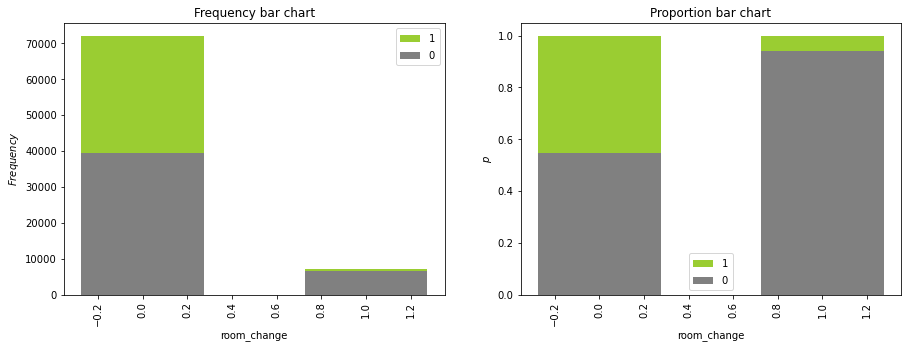

In [43]:
#CREATE room_change , If assigned different room
data['room_change'] = np.where(data['ReservedRoomType'] !=data['AssignedRoomType'], 1, 0)
bar_charts_categorical(data, 'room_change', 'IsCanceled')

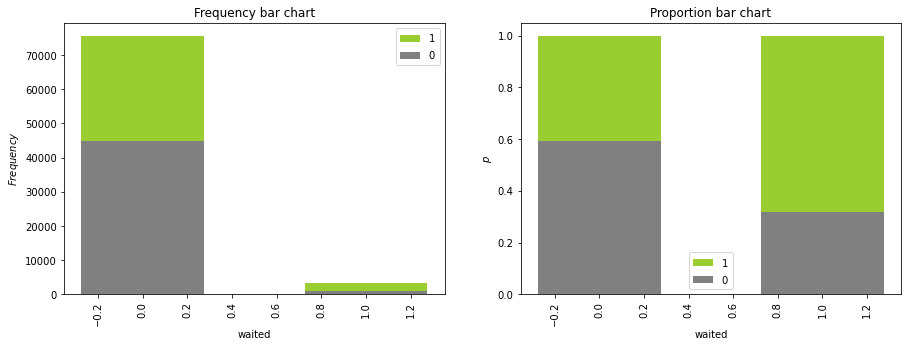

In [44]:
#DaysInWaitingList
data['waited'] = np.where(data['DaysInWaitingList'] ==0 , 0, 1)
data.drop('DaysInWaitingList',axis=1,inplace=True)
bar_charts_categorical(data, 'waited', 'IsCanceled')

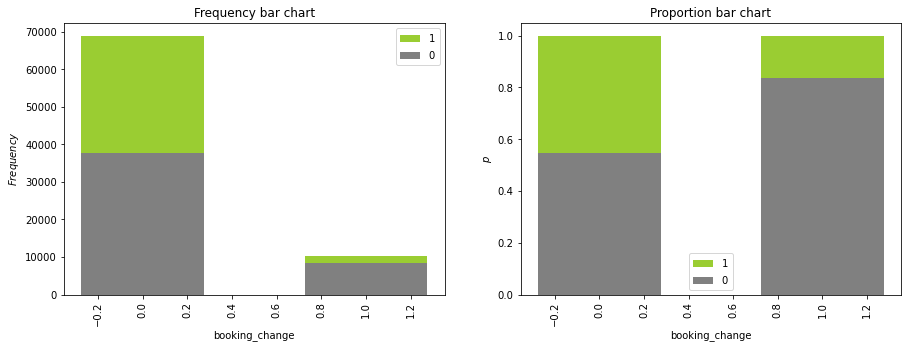

In [45]:
#Made any booking change?
data['booking_change'] = np.where(data['BookingChanges'] ==0 , 0, 1)
data.drop('BookingChanges',axis=1,inplace=True)      
bar_charts_categorical(data, 'booking_change', 'IsCanceled')

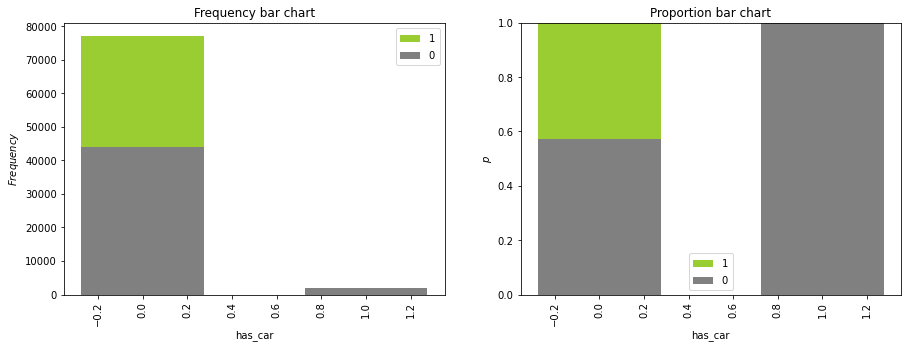

In [46]:
#Has car??
data['has_car'] = np.where(data['RequiredCarParkingSpaces'] ==0 , 0, 1)
data.drop('RequiredCarParkingSpaces',axis=1,inplace=True)      
bar_charts_categorical(data, 'has_car', 'IsCanceled')

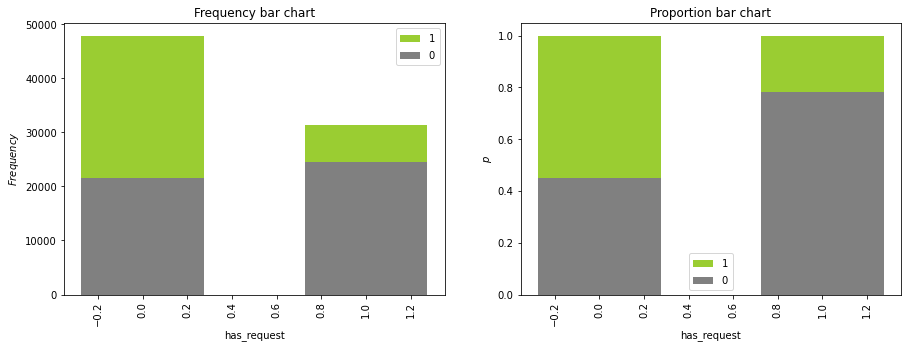

In [47]:
#SpecialRequests
data['has_request'] = np.where(data['TotalOfSpecialRequests'] ==0 , 0, 1)
data.drop('TotalOfSpecialRequests',axis=1,inplace=True)      
bar_charts_categorical(data, 'has_request', 'IsCanceled')

Total count  Cancelled      %
IsRepeatedGuest                               
0                      77184      32640  42.29
1                       1977        439  22.21

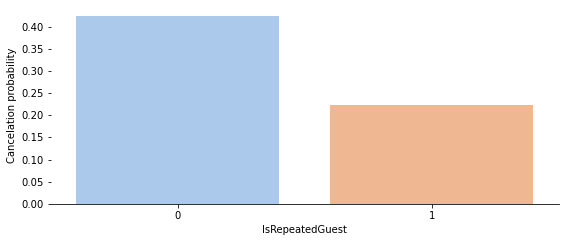

In [48]:
weight_of_variable(data,column='IsRepeatedGuest',target='IsCanceled')

In [49]:
#create new variable named CancellationRate
#replace nans with the probability of first time customer probability of cancellation
data['CancellationRate'] = data['PreviousCancellations']/(data['PreviousCancellations']+data['PreviousBookingsNotCanceled'])
data['CancellationRate'] = data['CancellationRate'].fillna(0.42)

#drop two columns
data.drop(['PreviousCancellations', 'PreviousBookingsNotCanceled'], axis=1, inplace=True)

## **3.4. Feature Selection** <a class="anchor" id="3.4"></a>

In [50]:
drop_columns

['ArrivalDateMonth',
 'DepositType',
 'ReservationStatus',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'Country']

In [51]:
# unwanted columns from EDA
data.drop(drop_columns, axis=1, inplace=True)

In [52]:
data.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateWeekNumber',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Meal', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest',
       'ReservedRoomType', 'AssignedRoomType', 'Agent', 'CustomerType', 'ADR',
       'ReservationStatusDate', 'has_Babies', 'total_guests', 'room_change',
       'waited', 'booking_change', 'has_car', 'has_request',
       'CancellationRate'],
      dtype='object')

In [53]:
phik = data.phik_matrix()

interval columns not set, guessing: ['IsCanceled', 'LeadTime', 'ArrivalDateWeekNumber', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'IsRepeatedGuest', 'ADR', 'has_Babies', 'total_guests', 'room_change', 'waited', 'booking_change', 'has_car', 'has_request', 'CancellationRate']


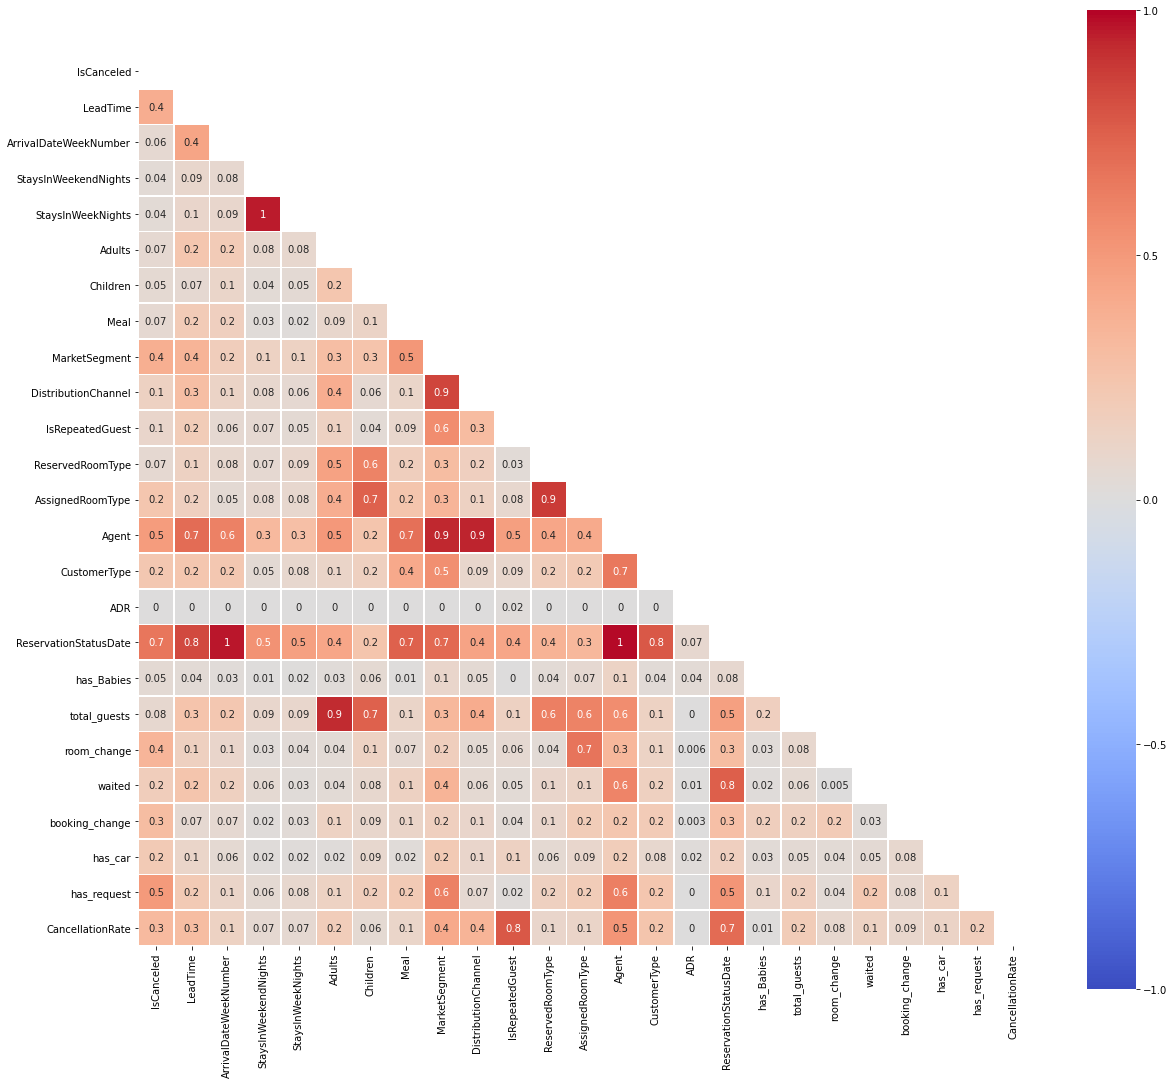

In [54]:
mask = np.zeros_like(phik, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(20, 30)) 
heatmap = sns.heatmap(phik, 
                      square = True,
                      mask = mask,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1g',
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 10})
#add the column names as labels
ax.set_yticklabels(phik.columns, rotation = 0)
ax.set_xticklabels(phik.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [55]:
#from the heatmap above we can see strong correlation (>0.8) between features ReservationStatusDate and DistributionChannel and others independent vars
data = data.drop(['ReservationStatusDate', 'DistributionChannel'], axis=1)

In [56]:
#generating correlation in respect to our target 'IsCanceled'
corr_canceled = phik["IsCanceled"]
corr_canceled.abs().sort_values(ascending=False)

IsCanceled               1.000000
ReservationStatusDate    0.661515
has_request              0.497134
Agent                    0.486511
LeadTime                 0.394423
MarketSegment            0.388983
room_change              0.350487
CancellationRate         0.317380
booking_change           0.304579
AssignedRoomType         0.241378
CustomerType             0.230461
has_car                  0.208091
waited                   0.177367
DistributionChannel      0.141767
IsRepeatedGuest          0.099362
total_guests             0.076042
ReservedRoomType         0.069278
Meal                     0.068452
Adults                   0.067810
ArrivalDateWeekNumber    0.064394
Children                 0.054727
has_Babies               0.052307
StaysInWeekNights        0.042807
StaysInWeekendNights     0.039818
ADR                      0.000000
Name: IsCanceled, dtype: float64

## **3.5. Encoding** <a class="anchor" id="3.5"></a>

In [57]:
data.columns[(data.dtypes != 'O')]

Index(['IsCanceled', 'LeadTime', 'ArrivalDateWeekNumber',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'IsRepeatedGuest', 'ADR', 'has_Babies', 'total_guests', 'room_change',
       'waited', 'booking_change', 'has_car', 'has_request',
       'CancellationRate'],
      dtype='object')

In [58]:
metric = ['LeadTime','ArrivalDateWeekNumber', 'Adults', 'Children', "StaysInWeekNights","StaysInWeekendNights", 'total_guests', 'ADR', 'CancellationRate']
non_metric= data.columns.drop(metric)
non_metric= non_metric.drop(target)

In [59]:
mean = data['IsCanceled'].mean()
for i in non_metric:
    agg = data.groupby(i)['IsCanceled'].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    weight  = 100
    #smoothed means
    smooth = (counts * means + weight * mean) / (counts + weight)
    data.loc[:, i + '_enc'] = data[i].map(smooth)

In [60]:
df_enc = data.drop(non_metric, axis=1)

## 3.6. Scaling  <a class="anchor" id="3.6"></a>

In [61]:
scaler2 = MinMaxScaler()
# fit and transform the data
df_enc[df_enc.columns] = scaler2.fit_transform(df_enc)
df_enc.reset_index(inplace = True)
df_enc.drop('index', axis=1, inplace=True)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_enc.drop('IsCanceled', axis=1), df_enc[target], test_size=0.3, random_state=5, stratify=df_enc[target])

In [63]:
# Check for shape of dataset
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (55412, 22)
Test set: (23749, 22)


# **4. Modeling** <a class="anchor" id="4"></a>

In [91]:
ran_state = 2
models = []
#Logistic Regression
models.append(('LogRegression', LogisticRegression(random_state=ran_state)))
# SGDC which is also a linear classisifer
models.append(('SGDC', SGDClassifier(random_state=ran_state)))
#KNN
models.append(('KNN', KNeighborsClassifier()))
#Decision Tree 
models.append(('DT', DecisionTreeClassifier(random_state=ran_state)))
#Random Forest
models.append(('RandomForest', RandomForestClassifier(random_state=ran_state)))
#Linear support Vector Machine 
models.append(('LinearSVC', LinearSVC(random_state=ran_state)))
# Gradient Boosting
models.append(('GradientBoost', GradientBoostingClassifier(random_state=ran_state)))
#XGBoost
models.append(('XGBoost', XGBClassifier(eval_metric='logloss')))

# evalutate each model in turn
results = []
names = []
scores = {}
for name, model in models:
    # Set up kfold with number of splits = 10
    kfold = KFold(n_splits=10)
    # start counting time
    begin = time.perf_counter()
    # Run cross-validation on training set
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    # finish counting time
    end = time.perf_counter()
    
    results.append(cv_results)
    names.append(name)
    # assign infomation
    avg_time = (end-begin)/10
    avg_score = round(np.mean(cv_results),4)
    std_score = round(np.std(cv_results),3)
   # precision_score(X_train, y_train)
    precision = round(np.mean(cross_val_score(model, X_train, y_train, cv=kfold, scoring='average_precision')),4)
    # assign infomation
    scores[name] = [avg_score, '+/-' + str(std_score), precision, round(avg_time,3)]

final_score = pd.DataFrame.from_dict(scores,orient='index',columns=['Average score','Std', 'Precision', 'Average training time'])
final_score

Average score       Std  Precision  Average training time
LogRegression         0.7998  +/-0.007     0.8559                  1.230
SGDC                  0.8009  +/-0.009     0.8538                  0.528
KNN                   0.8284  +/-0.005     0.8541                 11.877
DT                    0.8266  +/-0.006     0.7210                  0.618
RandomForest          0.8633  +/-0.004     0.9255                 11.060
LinearSVC             0.8025  +/-0.008     0.8556                  4.854
GradientBoost         0.8222  +/-0.005     0.8854                 12.134
XGBoost               0.8506  +/-0.006     0.9149                  2.855

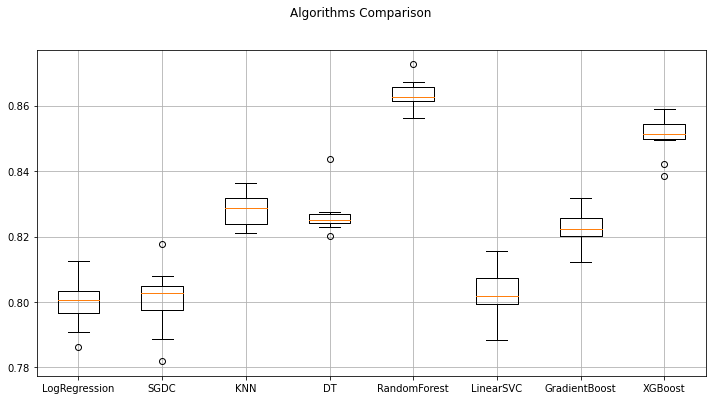

In [92]:
# Plot the result
fig = plt.figure()
fig.set_size_inches(12,6)
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(names)
ax.grid(True)
plt.show()

In [66]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train,digits=4))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val,digits=4))
    print(confusion_matrix(y_val, pred_val))


## 4.1 Random Forest <a class="anchor" id="4.1"></a>

In [67]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5, 7, 9],
              "max_features": [1, 3, 7, 10],
              "min_samples_split": [3, 10, 50],
              "min_samples_leaf": [3, 10, 50],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=10, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_, gsRFC.best_estimator_

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 64.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 96.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 119.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 154.9min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 176.7min finished


(0.8287554193140847,
 RandomForestClassifier(bootstrap=False, max_depth=9, max_features=10,
                        min_samples_leaf=3, min_samples_split=10,
                        n_estimators=300))

In [67]:
model_RFC_final = RandomForestClassifier(bootstrap=False, max_depth=9, max_features=10,
                                            min_samples_leaf=3, min_samples_split=10, n_estimators=300)
model_RFC_final.fit(X_train,y_train)
y_train_predicted = model_RFC_final.predict(X_train)
y_test_predicted = model_RFC_final.predict(X_test)

In [68]:
metrics(y_train,y_train_predicted,y_test,y_test_predicted)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.8059    0.9337    0.8651     32257
         1.0     0.8814    0.6868    0.7720     23155

    accuracy                         0.8305     55412
   macro avg     0.8437    0.8102    0.8186     55412
weighted avg     0.8375    0.8305    0.8262     55412

[[30118  2139]
 [ 7253 15902]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

## 4.2 Gradient Boosting <a class="anchor" id="4.2"></a>

In [69]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier(random_state=10)
gb_param_grid = {'loss' : ["deviance", 'exponential'],
              'learning_rate': [0.1, 0.07,0.05,0.03, 0.01], 
              'n_estimators':[60,100,150,200,500,700], 
              'max_features':[7], 
              'subsample':[0.8],
              'min_samples_leaf':[15],
              'min_samples_split' : [120],
              'max_depth' :[4]
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=KFold(n_splits=10), scoring="accuracy", n_jobs= -1, verbose = 1)
gsGBC.fit(X_train,y_train)
GBC_best = gsGBC.best_estimator_
# Best score
gsGBC.best_score_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 33.9min finished


0.8452138778988898

In [70]:
gsGBC.best_estimator_

GradientBoostingClassifier(max_depth=4, max_features=7, min_samples_leaf=15,
                           min_samples_split=120, n_estimators=700,
                           random_state=10, subsample=0.8)

In [71]:
model_GBC_final = GradientBoostingClassifier(
                                 max_depth=4, 
                                 max_features=7, 
                                 min_samples_leaf=15,                         
                                 min_samples_split=120,
                                 n_estimators=700, 
                                 subsample=0.8
                                 )
model_GBC_final.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=4, max_features=7, min_samples_leaf=15,
                           min_samples_split=120, n_estimators=700,
                           subsample=0.8)

In [72]:
y_train_predicted = model_GBC_final.predict(X_train)
y_test_predicted = model_GBC_final.predict(X_test)
metrics(y_train,y_train_predicted,y_test,y_test_predicted)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.8471    0.9248    0.8842     32257
         1.0     0.8799    0.7674    0.8198     23155

    accuracy                         0.8590     55412
   macro avg     0.8635    0.8461    0.8520     55412
weighted avg     0.8608    0.8590    0.8573     55412

[[29832  2425]
 [ 5386 17769]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

## 4.3 XGBoost <a class="anchor" id="4.3"></a>

In [84]:
estimator = XGBClassifier(
    eval_metric='auc'
)
parameters = {
    
    'max_depth': [2, 3, 5, 7, 10],
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train,y_train)
print(grid_search.best_estimator_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   40.1s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:  5.4min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [82]:
model_xgb_final = xgboost.XGBClassifier(eval_metric='auc',max_depth=10, learning_rate=0.1)
model_xgb_final.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [93]:
y_train_predicted = model_xgb_final.predict(X_train)
y_test_predicted = model_xgb_final.predict(X_test)
metrics(y_train,y_train_predicted,y_test,y_test_predicted)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.8611    0.9366    0.8973     32257
         1.0     0.8994    0.7895    0.8409     23155

    accuracy                         0.8752     55412
   macro avg     0.8803    0.8631    0.8691     55412
weighted avg     0.8771    0.8752    0.8737     55412

[[30213  2044]
 [ 4873 18282]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [94]:
# Fit model using each importance as a threshold
thresholds = sort(model_xgb_final.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_xgb_final, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(eval_metric='auc')
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.002, n=22, Accuracy: 85.52%
Thresh=0.006, n=21, Accuracy: 85.28%
Thresh=0.006, n=20, Accuracy: 85.29%
Thresh=0.006, n=19, Accuracy: 85.21%
Thresh=0.007, n=18, Accuracy: 85.26%
Thresh=0.008, n=17, Accuracy: 85.18%
Thresh=0.008, n=16, Accuracy: 85.38%
Thresh=0.008, n=15, Accuracy: 85.39%
Thresh=0.008, n=14, Accuracy: 85.25%
Thresh=0.008, n=13, Accuracy: 84.87%
Thresh=0.008, n=12, Accuracy: 84.67%
Thresh=0.010, n=11, Accuracy: 84.00%
Thresh=0.015, n=10, Accuracy: 83.99%
Thresh=0.018, n=9, Accuracy: 81.74%
Thresh=0.028, n=8, Accuracy: 81.64%
Thresh=0.060, n=7, Accuracy: 81.39%
Thresh=0.062, n=6, Accuracy: 77.55%
Thresh=0.062, n=5, Accuracy: 75.15%
Thresh=0.095, n=4, Accuracy: 74.60%
Thresh=0.139, n=3, Accuracy: 72.25%
Thresh=0.201, n=2, Accuracy: 65.61%
Thresh=0.237, n=1, Accuracy: 64.63%


# **5. Evaluation** <a class="anchor" id="5"></a>

In [95]:
def plot_models_roc_curve(models,X_train,y_train, X_test, y_test):
    fig ,ax = plt.subplots(figsize = (8,8))
    for model in models:
        model.fit(X_train, y_train)
        plot_roc_curve(model, X_test, y_test,ax = ax)      

    plt.title("ROC curve comparison")
    plt.show() 

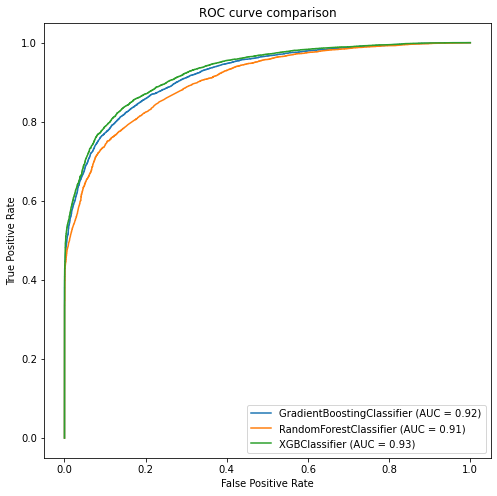

In [96]:
plot_models_roc_curve([model_GBC_final,model_RFC_final,model_xgb_final],
                      X_train, y_train,X_test,y_test)

## 5.1 Stacking <a class="anchor" id="5.1"></a>

In [97]:
rf = model_RFC_final
gb = model_GBC_final
xg = model_xgb_final

In [98]:
# https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
# http://ml-ensemble.com/info/tutorials/start.html#multi-layer-ensembles
### Find the best combination of stacking

seed = 2
np.random.seed(seed)

names = ['Random Forest', 'Gradient Boosting', 'XGBoost']
clf_array = [rf, gb, xg]

def zip_stacked_classifiers(clf_array, names):
    a = []
    clf_zip = []
    name_zip = []    
    for i in range(2, len(clf_array) + 1):
        combined_items = [list(x) for x in list(combinations(clf_array, i))]
        clf_zip = clf_zip+combined_items 
    for i in range(2, len(names) + 1):
        combined_items = [list(x) for x in list(combinations(names, i))]
        name_zip = name_zip+ combined_items    
    return list(zip(clf_zip,name_zip))

stacked_clf_list =zip_stacked_classifiers(clf_array, names)
best_combination = [0.00, ""]
accuracy_dict = {}
for clf in stacked_clf_list:   
    ensemble = SuperLearner(scorer = accuracy_score, 
                            random_state = seed, 
                            folds = 10)
    ensemble.add(clf[0])
    ensemble.add_meta(LogisticRegression())
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    accuracy_dict[str(clf[1])] = accuracy
    if accuracy > best_combination[0]:
        best_combination[0] = accuracy
        best_combination[1] = clf[1]
    
    print("Accuracy score: %.4f - %s" %(accuracy, clf[1]))
    
print("\nBest stacking model is %s with accuracy of: %.4f" %(best_combination[1], best_combination[0]))

Accuracy score: 0.8470 - ['Random Forest', 'Gradient Boosting']
Accuracy score: 0.8552 - ['Random Forest', 'XGBoost']
Accuracy score: 0.8552 - ['Gradient Boosting', 'XGBoost']
Accuracy score: 0.8543 - ['Random Forest', 'Gradient Boosting', 'XGBoost']

Best stacking model is ['Random Forest', 'XGBoost'] with accuracy of: 0.8552


In [99]:
estimators = [('xg',xg),('rf', rf)]
sc = StackingClassifier(estimators=estimators, 
                        final_estimator=LogisticRegression(),
                        stack_method='auto',
                         n_jobs=-1)

In [100]:
sc.fit(X_train, y_train)

StackingClassifier(estimators=[('xg',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              eval_metric='auc', gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=10,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=8,
                                              num_parallel_tree=1,
                  

In [101]:
y_train_predicted = sc.predict(X_train)
y_pred_sc = sc.predict(X_test)
metrics(y_train,y_train_predicted,y_test,y_pred_sc)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.8726    0.9305    0.9006     32257
         1.0     0.8933    0.8108    0.8500     23155

    accuracy                         0.8805     55412
   macro avg     0.8830    0.8706    0.8753     55412
weighted avg     0.8813    0.8805    0.8795     55412

[[30014  2243]
 [ 4381 18774]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

From the result, it is clear that the model of XGBoost showed the best performance

<AxesSubplot:>

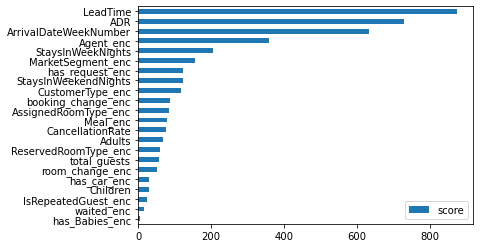

In [102]:
model = XGBClassifier(eval_metric='auc')
model.fit(df_enc.drop('IsCanceled', axis=1), df_enc[target])
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feat_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
feat_df.plot(kind='barh')

# **6. Deployment** <a class="anchor" id="6"></a>